# Tarefa 1: Remoção de interferências do sinal da rede eléctrica - 60 Hz


Largura	 de	banda do sinal de interferência - 60 Hz

Para remover as interferencias mencionadas: Filtro Stop Banda (Rejeita Banda)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt      #fazer o plot
import numpy as np

from scipy.signal import freqz, butter, lfilter #scipy conjunto de packs para calculo cientifico
# ver documeentacao: freqz?

# Visualização do sinal com ruido - ecg2x60.dat

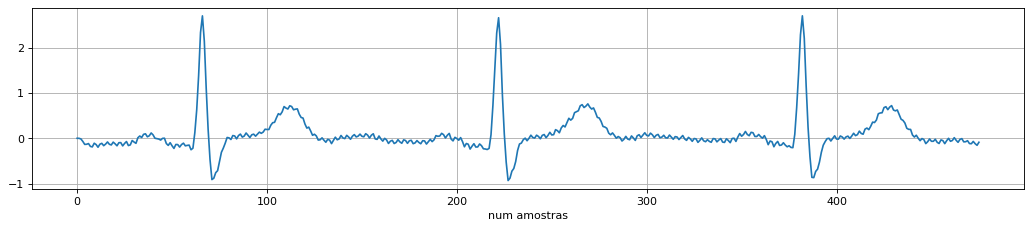

In [3]:
from matplotlib.pyplot import figure
# -- Sinal corrompido

figure(num=None, figsize=(16, 3), dpi=80, facecolor='w', edgecolor='k')
data = np.loadtxt('ecg2x60.dat')
plt.plot(data,label='Sinal corrompido')
#plt.plot(t1, data, 'b')
plt.grid(True)
plt.xlabel('num amostras')
plt.show()

# Filtro Rejeita Banda: Projecto do Filtro IIR

### Especificação

In [4]:
# Filtro rejeita Banda
fs = 200  # frequencia de amostragem
low_cut = 55
high_cut = 65   # freq de corte
order=11

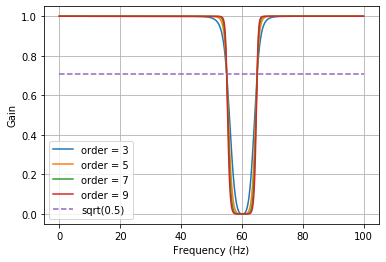

In [5]:
# devolve os coeficoentes de H(z) digital
def butter_bandstop(low_cut, high_cut, fs, order): # low_cut frequencia de corte  da freq analogica em hertz e a ordem do meu filtro : 5
    '''Nota: a função butter assume que a frequência de corte da especificação foi
    normalizada pela frequência de Nyquist'''
    nyquist = 0.5 * fs # freq nyquist é metade da freq de amostragem 
    low = low_cut / nyquist # normalizacao
    high = high_cut / nyquist
    b, a = butter(order, [low, high], btype='bandstop') # butter -> calcula se eu der a ordem e a freq de corte e o tipo(low) ele retorna o b e a (butter?) em que b e a sao coeficientes do polinomio do numerador e denominador de H(z) ou H(s) -> depende, se tou a definir a freq do meu filtro anal ou digital
    return b, a # flag analog(butter?) por defenicao é false. Se for V, b e a são do filtro analog em S. Se é falso é do filtro digital em Z
# dou analogica e devolve digital

#para ver as frequencias do meu filtro, o plot -> é identica a anterior
def bpf_freq_resp(orders, low_cut, high_cut, fs):
    plt.figure()
    
    for order in orders:
        b, a = butter_bandstop(low_cut, high_cut, fs, order=order)
        W, H = freqz(b, a, worN=2000)   # - Frequência no tempo discreto
        plt.plot((fs * 0.5 / np.pi) * W, abs(H), label="order = %d" % order)
    
    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)], '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')
    
bpf_freq_resp([3, 5, 7, 9], low_cut, high_cut, fs)
#freqz?
# reposta para diferentes ganhos: 3, 5, 7 e 9
# na freq de amostragem ? têm o msm ganho: -3 dB

Da vizualização do gráfico anterior, optamos por escolher a ordem 9 para o projeto do filtro IIR. Esta ordem "corta" a frequencia de 60 HZ.

A resposta na frequência do filtro nunca se anula, haverá
sempre aliasing. Esta é uma das limitações do método da invariância da resposta impulsional. Deste modo, utilizamos de seguida o método da transformação bilinear, que mapeia todo o eixo jw do plano s no circulo unitário do plano z

### Resposta em frequencia do filtro analógico

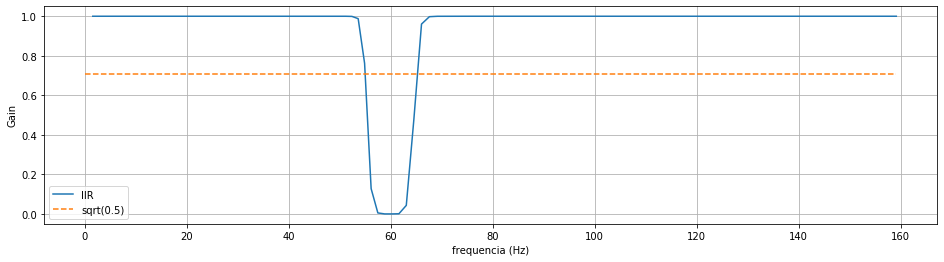

In [6]:
import scipy.signal as ss
# Coeficiente de H(s). Do filtro analogico
bf = 2 * np.pi * np.array([low_cut, high_cut])
order = 7
b, a = ss.butter(order, bf, btype='bandstop', analog=True)
ws, hs = ss.freqs(b, a) 

plt.figure(figsize=(16, 4))
plt.plot((0.5 / np.pi) * ws, np.abs(hs), label='IIR')
plt.plot([0, 0.5 * ws[-1] / np.pi], [np.sqrt(0.5), np.sqrt(0.5)], '--', label='sqrt(0.5)')
plt.grid(True)
plt.ylabel('Gain')
plt.legend(loc='best')
_ = plt.xlabel('frequencia (Hz)')

## Transformação Bilinear

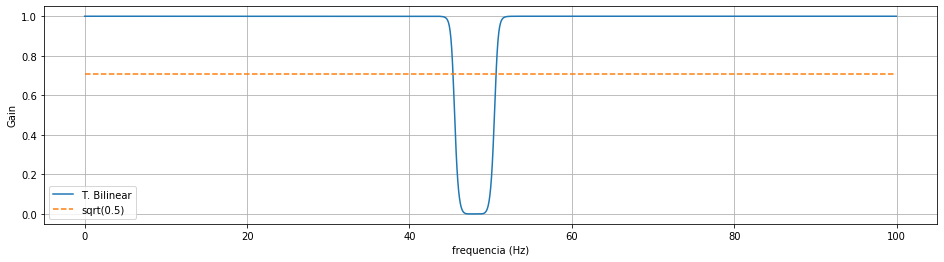

In [7]:
# Coeficientes de H(z)
bb, ba = ss.bilinear(b, a, fs)
wz, Hz = ss.freqz(bb, ba, worN=2000)

plt.figure(figsize=(16, 4))
plt.plot((0.5 / np.pi) * wz * fs, np.abs(Hz), label='T. Bilinear')
plt.plot([0, 0.5 * wz[-1] * fs / np.pi], [np.sqrt(0.5), np.sqrt(0.5)], '--', label='sqrt(0.5)')
plt.ylabel('Gain')
plt.legend(loc='best')
plt.grid(True)
_ = plt.xlabel('frequencia (Hz)')

### Sobreposição da resposta em frequencia do filtro analogico e da transformação biliniar

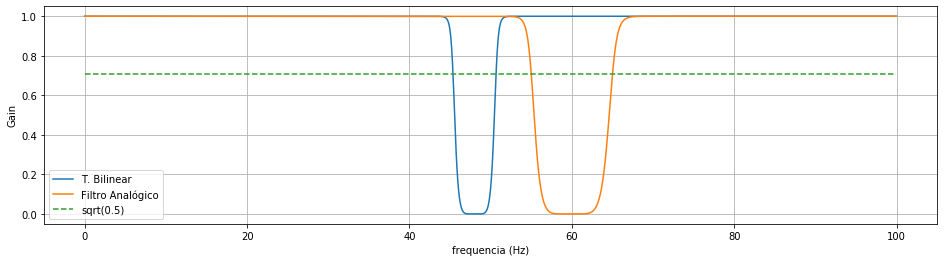

In [8]:
bb, ba = ss.bilinear(b, a, fs)
wz, Hz = ss.freqz(bb, ba, worN=2000)
ws_1, Hs = ss.freqs(b, a, worN=wz*fs)

plt.figure(figsize=(16, 4))
plt.plot((0.5 / np.pi) * wz * fs, np.abs(Hz), label='T. Bilinear')
plt.plot((0.5 / np.pi) * ws_1, np.abs(Hs), label='Filtro Analógico')

plt.plot([0, 0.5 * wz[-1] * fs / np.pi], [np.sqrt(0.5), np.sqrt(0.5)], '--', label='sqrt(0.5)')
plt.ylabel('Gain')
plt.legend(loc='best')
plt.grid(True)
_ = plt.xlabel('frequencia (Hz)')

Devido à natureza não linear da transformação bilinear, as frequências indicadas na especificação do filtro foram deslocadas. Deste modo, para corrigir o problema,  foi feito o prewarping das respectivas frequências

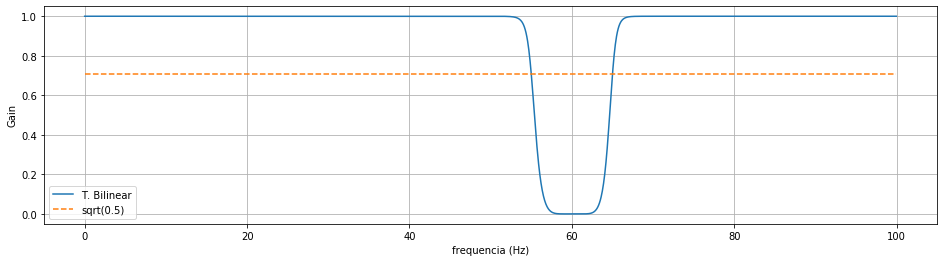

In [9]:
# Vamos fazer o pre-warping das frequências
def prewarping(fo, fs):
    return 2 * fs * np.tan(np.pi * fo / fs)

bf = [prewarping(low_cut, fs), prewarping(high_cut, fs)]
order = 7
bp, ap = ss.butter(order, bf, btype='bandstop', analog=True)

bbp, bap = ss.bilinear(bp, ap, fs)
#transformacao bilinear para transformar no filtro digital
wz, Hz = ss.freqz(bbp, bap, worN=2000)

plt.figure(figsize=(16, 4))
plt.plot((0.5 / np.pi) * wz * fs, np.abs(Hz), label='T. Bilinear')

plt.plot([0, 0.5 * wz[-1] * fs / np.pi], [np.sqrt(0.5), np.sqrt(0.5)], '--', label='sqrt(0.5)')
plt.ylabel('Gain')
plt.legend(loc='best')
plt.grid(True)
_ = plt.xlabel('frequencia (Hz)')


Como é possível observar, através do prewarping, as frequencias deslocadas pela transformação biliniar foram corrigidas

### Diagrama de Polos e Zeros


(14, 14)

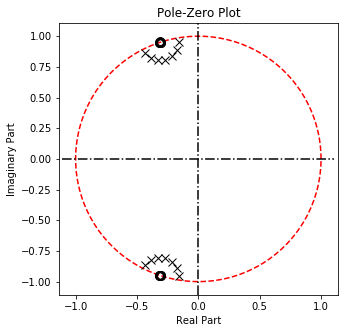

In [10]:
from plots import zplane # vou ao ficheiro

zplane(bbp, bap)

Da observação do diagrama de polos e zeros, podemos concluir que, uma zer que os polos estã no interior do ciuculo unitario o filtro é realizavel. Apresenta 14 polos e 14 zeros. Os polos e os zeros são conjugados. 

### Filtragem do Sinal

Ordem = 7; 
Filtro IIR rejeita banda;
Banda rejeitada: 55 Hz - 65 Hz


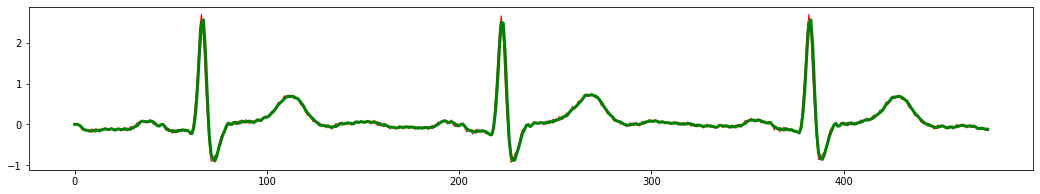

In [11]:
y = lfilter(bbp, bap, data)
plt.figure(figsize=(18, 3))
plt.plot(data, 'r', linewidth=1)
_ = plt.plot(y, 'g', linewidth=3)

#Verde -> sinal filtrado
#laranja -> sinal original

## Filtro FIR Rejeita Banda: Projecto do Filtro Digital


### Especificação

In [12]:
fs = 200  # frequencia de amostragem
low_cut = 55
high_cut = 65   # freq de corte
width = 5   # banda de transicao
ripple_db = 80.0   # ripple na banda passante 
# Utilizada a janela de keiser

In [13]:
# filtrar o meu sinal
nyquist = fs / 2

low = low_cut / nyquist # normalizada
high = high_cut / nyquist
width = 5 / nyquist # largura -> normalizada
ripple_db = 60.0   # ripple na banda passante 

# calcular o num taps e o B -> kaiserord
#     passo a atenuacao e a largura do filtro banda e fornece o B porque as freq estao normalizadas
num_taps, beta = ss.kaiserord(ripple_db, width)
#calculo a ordem e o B

#ss.firwin?

taps = ss.firwin(num_taps, [low, high], window=('kaiser', beta), pass_zero='bandstop') # calculo os coeficientes -> taps
# ele vai apanhar o filtro ideal e multipicar a sua resp impulsional pela janela consoante se é pass baixo, alto ...
s_filtered = ss.lfilter(taps, 1.0, data) # filtro o meu sinal

### Resposta em frequencia do FIR com a janela de Keiser

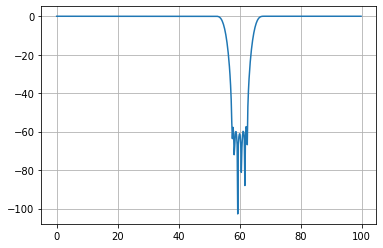

In [14]:
W, H = ss.freqz(taps, [1])

plt.figure()
plt.plot((fs * 0.5 / np.pi) * W, 20 * np.log10(abs(H)))
plt.grid()

# atenuacao de -60 dB está certo

### Diagrama de Polos e Zeros


(146, 73)

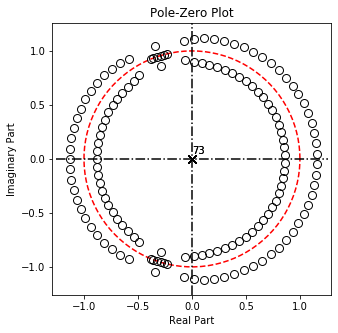

In [15]:
zplane(taps, [1])

O diagrama de polos e zeros apresenta 146 zeros e 73 polos. Todos os polos estão na origem do referencial

### Filtragem do Sinal

Janela de Keiser; 
Ordem = 146;  
Filtro FIR rejeita banda;
banda de rejeição: 55 Hz - 65 Hz
largura da banda de transição = 5 Hz; 
ripple = 60 dB;

-0.30901699437494734

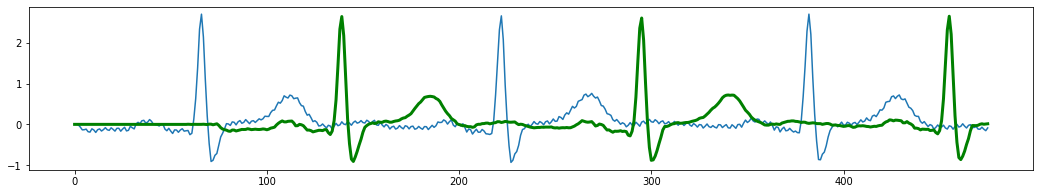

In [21]:
plt.figure(figsize=(18, 3))
plt.plot( data)
_ = plt.plot(s_filtered, 'g', linewidth=3)

# verde o sinal filtrado
# azul o sinal original - corrompido
np.cos(3*np.pi/5)

Da visualização dos sinais filtrado e original, podemos ver que o sinal filtrado (verde) apresenta um atraso em relação ao sinal original. Isto deve-se à inicialização do filtro. Quanto maior o número de taps, ordem, maior será o atraso.

### Filtros IIR vs FIR. Qual usar ?

Da observação dos gráficos obtidos da resposta na frequencia e do sinal filtrado usando as duas classes de filtros, O filtro FIR com a janela de Kaiser foi o que obteve melhores resultados. 

O filtro FIR conseguiu atenuar de forma eficaz as frequencias em torno de 60 Hz. O ganho na banda passante foi unitário (não houve ganho).


# Filtro sintonizado

A frequencia a ser eliminada é de 60 Hz. Como o espetro é bilateral, é necessário também eliminar a frequencia de - 60 Hz. A partir desta premissa (exemplificada no relatório), foi possível chegar à fórmula seguinte: 
$$H(z) = \frac{1 - 2*cos(\frac{3pi}{5})*z^{-1}+z^{-2}}{1 - 2*cos(\frac{3pi}{5})*αz^{-1}+αz^{-2}}$$

O valor de alfa (α) corresponde ao fator de sintonização

##### Diagrama de polos e zeros do filtro sintonizado

O melhor valor de alfa conseguido para o filtro sintonizado foi alfa = 0.95. Com este valor os polos não coincidem com os zeros e, estão suficientemente pertos para que não existem outras distorções no sinal

(2, 2)

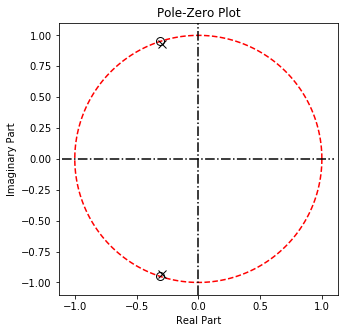

In [43]:
alfa = 0.95

b = [1, -2*np.cos(3*np.pi/5), 1]
a = [1, -2*np.cos(3*np.pi/5)*alfa, 1*alfa]  # o 4ac maior que b^2, ira ser complexo
zplane(b, a)


# Filtro sintonizado vs filtro FIR

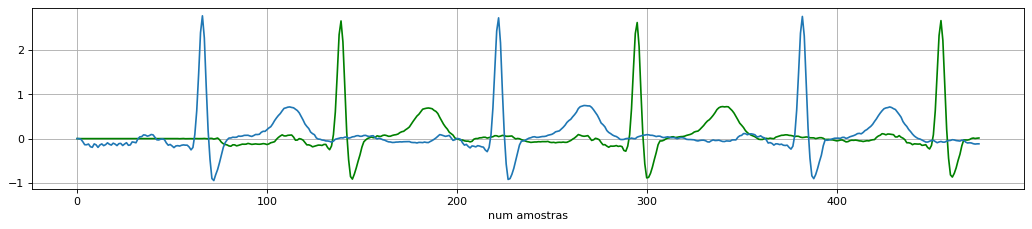

In [44]:
y = lfilter(b, a, data)  # filtro sintonizado

figure(num=None, figsize=(16, 3), dpi=80, facecolor='w', edgecolor='k')

_ = plt.plot(s_filtered, 'g')
plt.plot(y)
plt.grid(True)
plt.xlabel('num amostras')
plt.show()

No gráfico anterior podemos ver o filtro FIR representado a verde e o filtro sintonizado representado a azul. Uma vez que o filtro sintonizado não apresenta o problemas das consições iniciais, ou seja, as suas amostras não estão atrasadas, e o resto do sinal é semmelhante ao sinal filtrado com filtro FIR, perante isto, usaríamos o filtro sintonizado.

# Como eliminar	todos os harmónicos	do sinal da	rede eléctrica? 

Os harmonicos são frequncias múltiplas inteiras de uma frequencia fundamental. No caso da rede elétrica a frequencia fundamental é de 60 Hz, sendo o segundo harmônico 120 Hz, o terceiro harmônico 180 Hz e assim sucessivamente.

Como a frequência de amostragem é de 200 Hz, o filtro não pode deixar passar as frequencias de 60 Hz (frequencia fundamental), 120 Hz (primeiro harmonico) e 180 Hz (segundo harmonico).  Através do filtro sintonizado representado anteriormente, eliminamos a componente de 60 Hz. Repetindo o mesmo procedimento para as frequencias de 120 Hz e de 180 Hz, é possivel filtrar todos os harmónicos do sinal da rede elétrica. O diagrama de polos e zeros resultante, terá 6 polos e 6 zeros.
